# Projet de calcul scientifique

In [1]:
import scipy as sc
import numpy as np
from scipy import linalg as LS
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math
import os
%matplotlib notebook
from matplotlib.animation import FuncAnimation
import random

## __1__ - Modèle SIR

### Question

On modélise la propagation d'une épidémie par le modèle SIR:
$du/dt = f(u)$ avec $u \in {\mathbb R}^{3}$. Préciser $f$. Étude
d'existence et d'unicité de solutions, point fixes, stabilité,
invariants, comportement global...

### Réponse

On a $u = \begin{bmatrix} S \\ I \\ R\end{bmatrix}$ et $f : \begin{bmatrix} S \\ I \\ R\end{bmatrix} \rightarrow \begin{bmatrix} - \beta*S*I \\ \beta*S*I-\gamma*I \\ \gamma*I \end{bmatrix}$

<IPython.core.display.Javascript object>


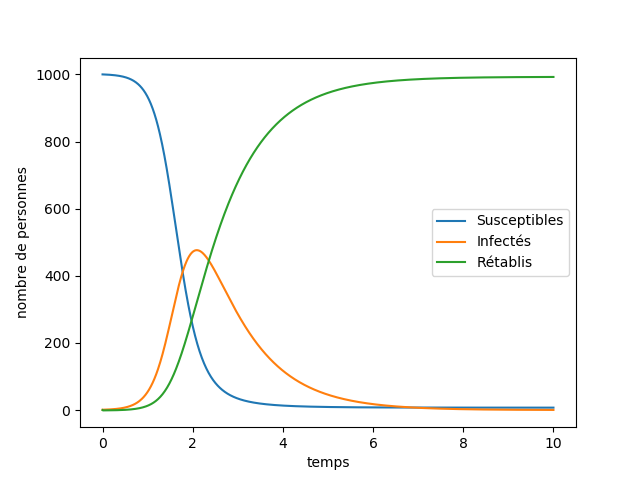

In [2]:
N=1000  #effectif de la population
s0 = N   #nombre de susceptible initial
i0 = 1  #nombre d'infectés initial
r0 = 0  #nombre de guéris ou morts initial

beta = 5  #coefficient de transmission
gamma = 1  #coefficient de "guérison"

dt = .01
T = 10   #durée de la simulation
Nt = int(T/dt)  #nombre d'itération

u = [s0,i0,r0]
Uplt = np.zeros((Nt,3))   #pour le plot
Uplt[0]=u

def zero_par_newton(g,x0,epsilon=1e-6,h=1e-4):
    x = x0
    while abs(g(x)) > epsilon:
            derivee = (g(x+h) - g(x)) / h
            x = x - g(x)/derivee
    return x

for t in range(1,Nt):
    def f_i(x):
        return x*(1-gamma*dt*(beta*u[0]/(gamma*N*(1+beta*dt*x/N)) - 1))-u[1]
    x0 = u[1]*(1+dt*(beta*u[0]/N - gamma))    #solution initiale par Euler explicite
    u[1] = zero_par_newton(f_i,x0,epsilon=1e-6,h=1e-4)
    u[0]=u[0]/(1+beta*dt*u[1]/N)
    u[2]=N-(u[0]+u[1])  #condition de conservation du nbre total
    Uplt[t]=u

tps = np.linspace(0,T,Nt)
plt.plot(tps,Uplt[:,0], label="Susceptibles")
plt.plot(tps,Uplt[:,1], label="Infectés")
plt.plot(tps,Uplt[:,2], label="Rétablis")
plt.xlabel('temps')
plt.ylabel('nombre de personnes')
plt.legend()

plt.show()

## __2__ - Modèle SIR avec diffusion

### Question

Une façon très naïve d'introduire de l'espace dans le modèle est de
considérer $u$ comme une fonction d'une variable d'espace $x$. Un
candidat naturel pour modéliser la diffusion de l'épidémie est
\begin{align*}
  \frac{\partial u}{\partial t} = D \frac{\partial^{2} u}{\partial x^{2}} + f(u)
\end{align*}
pour $x \in [0,1]$. Quelles conditions aux limites prendre ?
Dérivation de cette équation, rôle de $D$, points fixes, invariants,
comportement global des solutions... L'étude de l'existence et de
l'unicité de solutions est hors de portée pour l'instant (cf 2A
IMI et M2)


Résoudre l'équation ci-dessus par un schéma aux différences finies
(Euler explicite en temps, différences finies centrées en espace).
Comment valider votre résultat ?

Faire une étude de stabilité de la méthode d'Euler explicite sur
$\dot x = - \lambda x$, $\lambda > 0$, puis sur $\dot x = -A x$ où $A$
est une matrice symétrique définie positive. En déduire une relation
entre $\Delta t$ et $\Delta x$ pour le cas de l'équation de la
chaleur. Que se passe-t-il si cette condition n'est pas vérifiée ?

À quelle erreur vous attendez-vous en fonction de $\Delta x$ et
$\Delta t$? Vérifier numériquement.

Implémentez la méthode d'Euler implicite pour cette équation, et
résolvez le système obtenir par la méthode de Newton. Peut-on garantir
la convergence de la méthode de Newton? Quelle est la complexité de
cet algorithme par rapport au nombre de points $N$ ? Utiliser une
méthode d'inversion itérative. Quel est le coût par itération en
fonction de $N$ ? Quel est le coût total ?

### Réponse

\begin{equation}
\dfrac{\partial u}{\partial t} = D\dfrac{\partial^2 u}{\partial x^2} + f(u)
\end{equation}

Si on représente u par le vecteur $(s^T\ i^T\ r^T)$ où $s,i\ et\ r$ sont des vecteurs de taille $N_x$ (pour la discrétisation spatiale), on peut alors approximer le terme de diffusion $\dfrac{\partial^2 u}{\partial x^2}$ par une application de matrice sur le vecteur u. Par exemple pour $s$ :
    
\begin{equation}
\dfrac{\partial^2 s}{\partial x^2} \approx \dfrac{1}{dx^2}
\begin{pmatrix}
s_{N_x}-2s_0 +s_1 \\
s_0-2s_1 +s_2 \\
\vdots  \\
s_{N_x -1}-2s_{N_x} +s_0
\end{pmatrix} 
 = As
\end{equation} 


Avec $A = \dfrac{1}{dx^2}tridiag(1,-2,1)$ au détail près que dans la matrice $tridiag(1,-2,1)$ on a rajouté un $1$ en $(i,j) = (0,N_x)$ et $(i,j) = (N_x,0)$, cela caractérise des conditions aux limites périodiques (hypothèse valide ?). Ainsi on peut directement approcher le vecteur $\dfrac{\partial^2 u}{\partial x^2}$ en construisant une matrice $\tilde{A}$ par assemblage : 

\begin{equation*}
\tilde{A} = 
\begin{pmatrix}
A & 0 & 0 \\
0 & A & 0 \\
0 & 0 & A
\end{pmatrix}
\end{equation*}

Et donc $\dfrac{\partial^2 u}{\partial x^2} \approx \tilde{A}u$. Dans le cadre d'une telle approxiation on peut exprimer les schémas d'Euler explicite et implicite en résolvant : 

$$
\left\{
    \begin{array}{ll}
        \dfrac{u^{n+1}-u^n}{dt} = DAu^n + f(u^n) & \mbox{explicite } \\
        \dfrac{u^{n+1}-u^n}{dt} = DAu^{n+1} + f(u^n) & \mbox{implicite}
    \end{array}
\right.
$$

Où $u^n$ est l'approximation de la fonction spatiale $u(t = ndt,.)$. Pour le schéma implicite, on a fait le choix de ne pas écrire $f(u^{n+1})$ car dans le cas contraire on aurait à résoudre une équation bien plus complexe à chaque itération. On peut alors itérer selon l'inversion : 

$$
\left\{
    \begin{array}{ll}
        u^{n+1} = (I_{3N_x} + dtDA)u^n + dtf(u^n) & \mbox{explicite } \\
        u^{n+1} = (I_{3N_x} - dtDA)^{-1}DAu^{n} + dtf(u^n) & \mbox{implicite}
    \end{array}
\right.
$$

In [3]:
N = 1000 #effectif de la population
s0 = N   #nombre de susceptible initial
i0 = 1   #nombre d'infectés initial
r0 = 0   #nombre de guéris ou morts initial

beta = 5.  #coefficient de transmission
gamma = 1.  #coefficient de "guérison"
coef_diff = [.01,0.,.01]     #coefficient de diffusion (respectivement de s,i et r)

dt = .01
T = 10   #durée de la simulation
Nt = int(T/dt)  #nombre d'itération

dx = .01
L=1
Nx=int(L/dx)

#############répartition initiale de SIR############
u = np.zeros(3*Nx)
for x in range(Nx):
    u[x] = N*np.exp(-0.01*(x-Nx/2)**2)  #répartition des susceptibles
    u[x+Nx] = 10.*random.random()   #répartition des infectés
    u[x+2*Nx] = 0    #répartition des guéris/morts
    
#############Construction des matrices##############
B = -2*np.eye(Nx)
for i in range(Nx-1) : 
    B[i,i+1] = 1
    B[i+1,i] = 1
    
B[0,Nx-1]=1
B[Nx-1,0]=1

A = np.zeros((3*Nx,3*Nx))
D = np.zeros((3*Nx,3*Nx))

for k in range(3) : 
    A[k*Nx:(k+1)*Nx,k*Nx:(k+1)*Nx]=B
    D[k*Nx:(k+1)*Nx,k*Nx:(k+1)*Nx]=coef_diff[k]*np.eye(Nx)

A=(1/dx**2)*A   #matrice laplacien
Md=D.dot(A)

Mi = np.linalg.inv(np.eye(3*Nx)-dt*Md)  #pour implicite

#############Définition de la source##############
def f(uv):
    tab=np.zeros(3*Nx)
    for x in range(Nx) : 
        tab[x] = -beta*uv[x]*uv[x+Nx]/N
        tab[x+Nx] = beta*uv[x]*uv[x+Nx]/N -gamma*uv[x+Nx]
        tab[x+2*Nx]= gamma*uv[x+Nx]
    return tab

#Le tableau M va contenir toutes les itérations en temps du vecteur u
M = np.zeros((3*Nx,Nt)); 

#Initialisation 
M[:,0] = u; 

#############Schéma numérique##############
for t in range(1,Nt):
    #u=u + dt*(Md.dot(u)+f(u))    #explicite
    u = Mi.dot(u+dt*f(u))       #implicite (plus stable et plus "continu" que explicite)
    M[:,t]=u
    

<IPython.core.display.Javascript object>


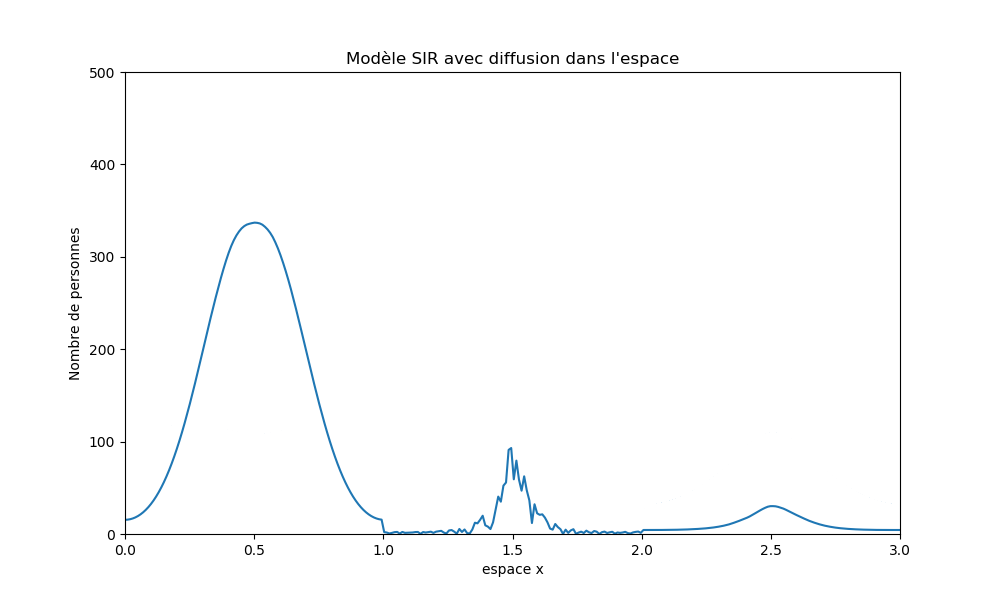

In [13]:
#############Plotting##############

esp = np.linspace(0,3*L,3*Nx)
fig, ax1 = plt.subplots(1, figsize = (10,6))
plotu,  = ax1.plot(esp,M[:,0])

ax1.set_xlabel('espace x')
ax1.set_ylabel('Nombre de personnes')


def animate(p):
    f = M[:,p]
    plotu.set_ydata(f)    
    
def init(): 
    ax1.set_xlim(0,3)
    ax1.set_ylim(0.,0.5*N)
    plt.title("Modèle SIR avec diffusion dans l'espace")
    return plotu,

step = 1
steps = np.arange(1,Nt,step)
ani = FuncAnimation(fig, animate,steps, init_func = init, interval = 10, blit = True)
plt.show()

Sur le graphique, S correspond à la portion [0,1], I à [1,2] et R à [2,3].

<IPython.core.display.Javascript object>


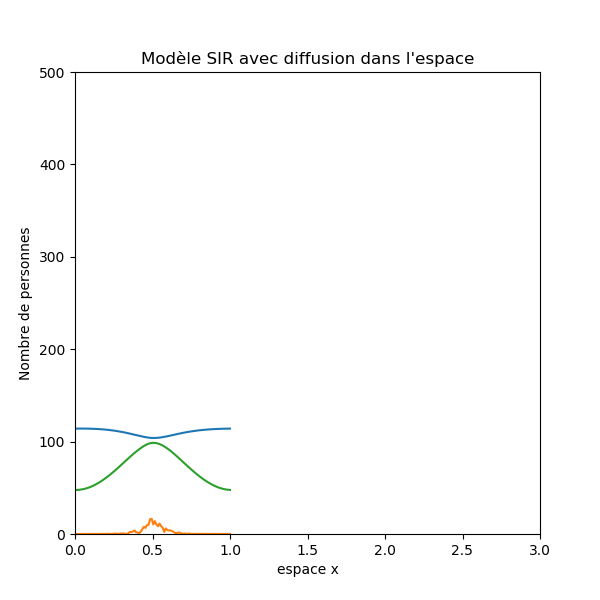

In [9]:
############# Test plotting Louise ##############

esp = np.linspace(0,L,Nx)
fig, ax1 = plt.subplots(1, figsize = (6,6))
plotu1,  = ax1.plot(esp,M[:Nx,0], label="Susceptibles")
plotu2,  = ax1.plot(esp,M[Nx:2*Nx,0], label="Infectés")
plotu3,  = ax1.plot(esp,M[2*Nx:3*Nx,0], label="Guéris")

ax1.set_xlabel('espace x')
ax1.set_ylabel('Nombre de personnes')


def animate(p):
    f1 = M[:Nx,p]
    plotu1.set_ydata(f1)
    f2 = M[Nx:2*Nx,p]
    plotu2.set_ydata(f2)
    f3 = M[2*Nx:3*Nx,p]
    plotu3.set_ydata(f3)
    
def init(): 
    ax1.set_xlim(0,1)
    ax1.set_ylim(0.,0.5*N)
    plt.title("Modèle SIR avec diffusion dans l'espace")
    return plotu1,

step = 1
steps = np.arange(1,Nt,step)
ani = FuncAnimation(fig, animate,steps, init_func = init, interval = 10, blit = True)
plt.show()

In [10]:
plt.close()

Le fait d'inclure des phénomènes de diffusion au modèle a pour conséquence que chacune des fonctions s,i et r s'homogénise spatialement au cours du temps. Est-ce vraiment un modèle fidèle à la réalité ?